In [1]:
!pip install opencv-python matplotlib numpy > /dev/null

import cv2
import matplotlib.pyplot as plt
import numpy as np

# 将附带的彩色图像（I0）转为灰度图像（记为I1）。

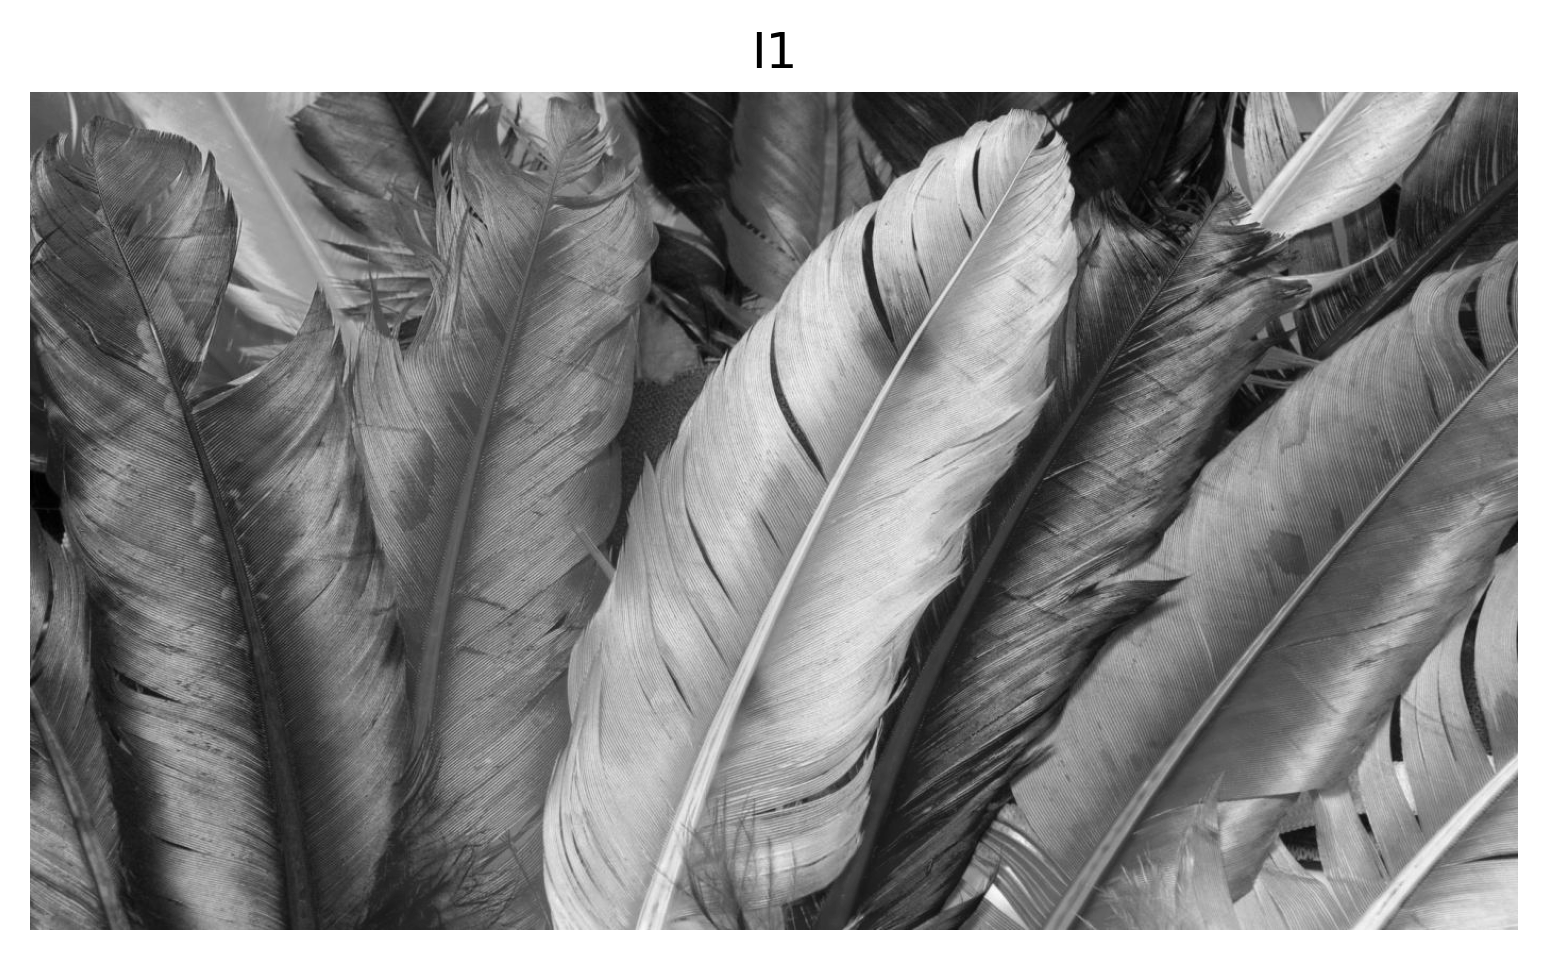

In [2]:
I0 = cv2.imread('./I0.jpg')
I1 = cv2.cvtColor(I0, cv2.COLOR_BGR2GRAY) 

plt.figure(dpi=300)
plt.axis('off')
plt.title('I1')
plt.imshow(I1, cmap='gray')
plt.show()

# 在白纸上手写“CV YYDS”几个字，手机拍照，转为与I1分辨率相同的二值图像（记为I2）。

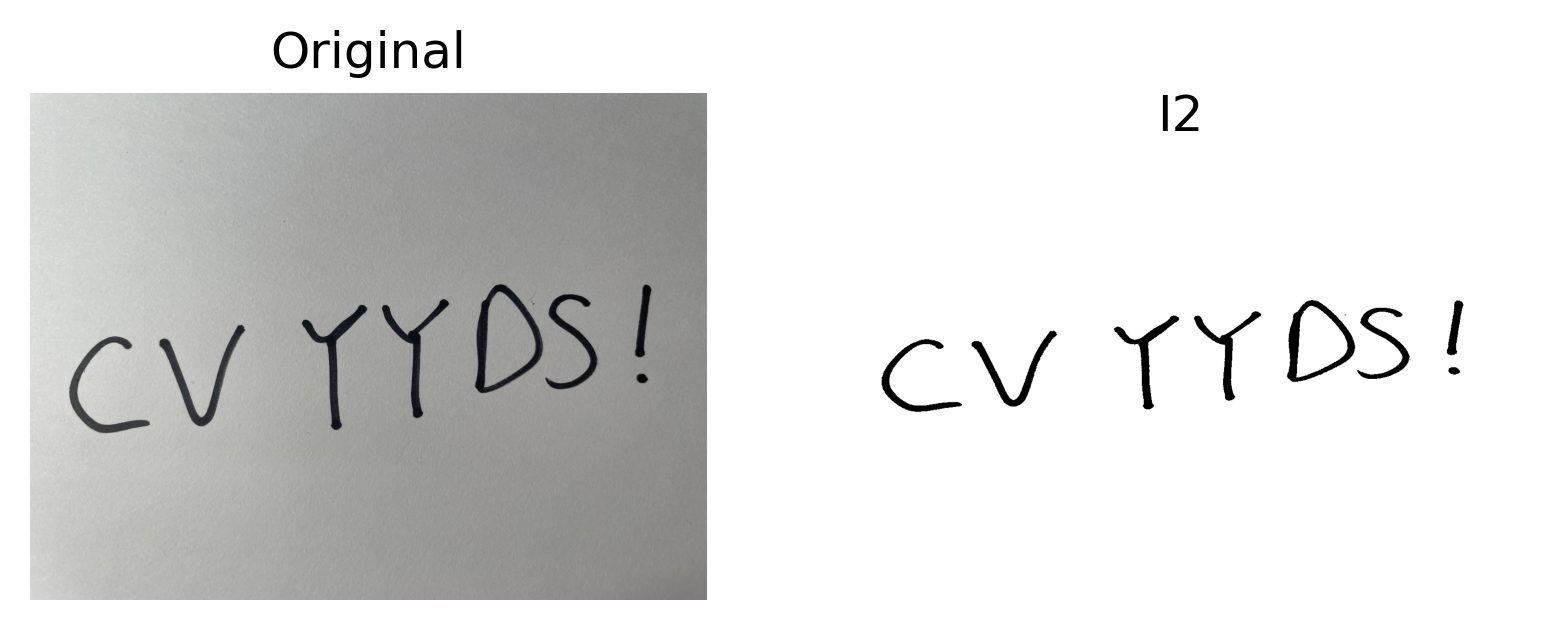

In [3]:
original = cv2.imread('./cv_yyds_original.jpg')
original_resize = cv2.resize(original, (I1.shape[1], I1.shape[0]), interpolation=cv2.INTER_CUBIC)
gray_resize = cv2.cvtColor(original_resize, cv2.COLOR_BGR2GRAY)
_, I2 = cv2.threshold(gray_resize,100,255,cv2.THRESH_BINARY)

plt.figure(dpi=300)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Original')
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('I2')
plt.imshow(I2, cmap='gray')
plt.show()

# 灰度图像每个像素的灰度值为1个字节（8位），按照从低到高记为L1、L2、…、L8。将I1中每个像素的L1、L2、…、L8分别用I2替换。对结果进行分析。

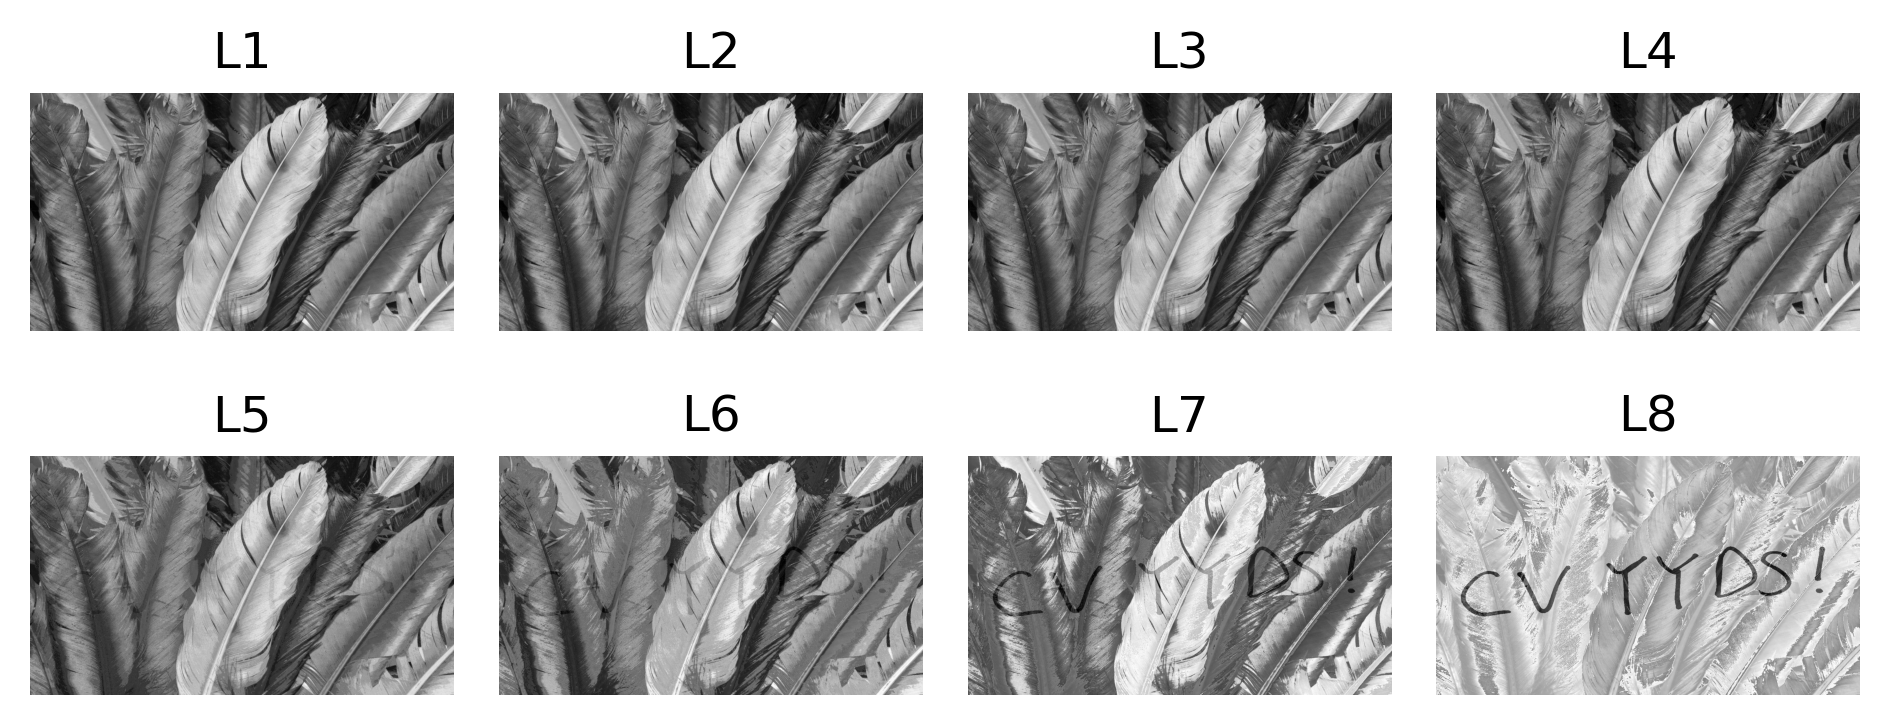

In [4]:
I2_binary = I2 // 255
plt.figure(dpi=300)
for bit in range(8):
    mask = 1 << bit
    I1_modified = (I1 & ~mask) | (I2_binary << bit)
    plt.subplot(2, 4, bit + 1)
    plt.axis('off')
    plt.title(f'L{bit + 1}')
    plt.imshow(I1_modified, cmap='gray')
    
plt.tight_layout()
plt.subplots_adjust(top=2, bottom=1.4)
plt.show()

## 分析

**低位替换（L1-L4）**：对于较低位的替换（如L1、L2、L3、L4），图像的整体外观变化不大。这是因为低位在像素的灰度值中所占的权重较小，即使这些位发生变化，也只会对灰度值造成微小的影响。

**高位替换（L5-L8）**：在高位的替换（特别是L7和L8）中，图像的整体外观发生显著变化。这是因为高位在像素灰度值中有更高的权重。L8的变化尤其显著，因为这一位决定了像素是否倾向于明或暗的大范围变化。可以看到在L7和L8图像中，“CV YYDS”出现得更加明显。

**二值图的影响**：在二值图像（I2）中，文字“CV YYDS”所在的区域是黑色的，其他部分是白色的。由于黑色对应的灰度值为0，白色对应的灰度值为255，这意味着在I2中，文字部分的所有位都是0，而其他部分都是1。所以在替换操作中，I1的对应文字部分区域的灰度值将被推向更低的灰度值，而其他部分灰度值被推向更高的灰度值（显得更“亮”）。结果是，在替换较高位时，“CV YYDS”会以较低的灰度值显现，这使得文字在视觉上变得非常突出。

**这实际上提供了一种添加水印的效果。**

# 将附带彩色图像（I0）的R、G、B通道中某个或某几个通道做与问题3类似的处理。对结果进行分析。

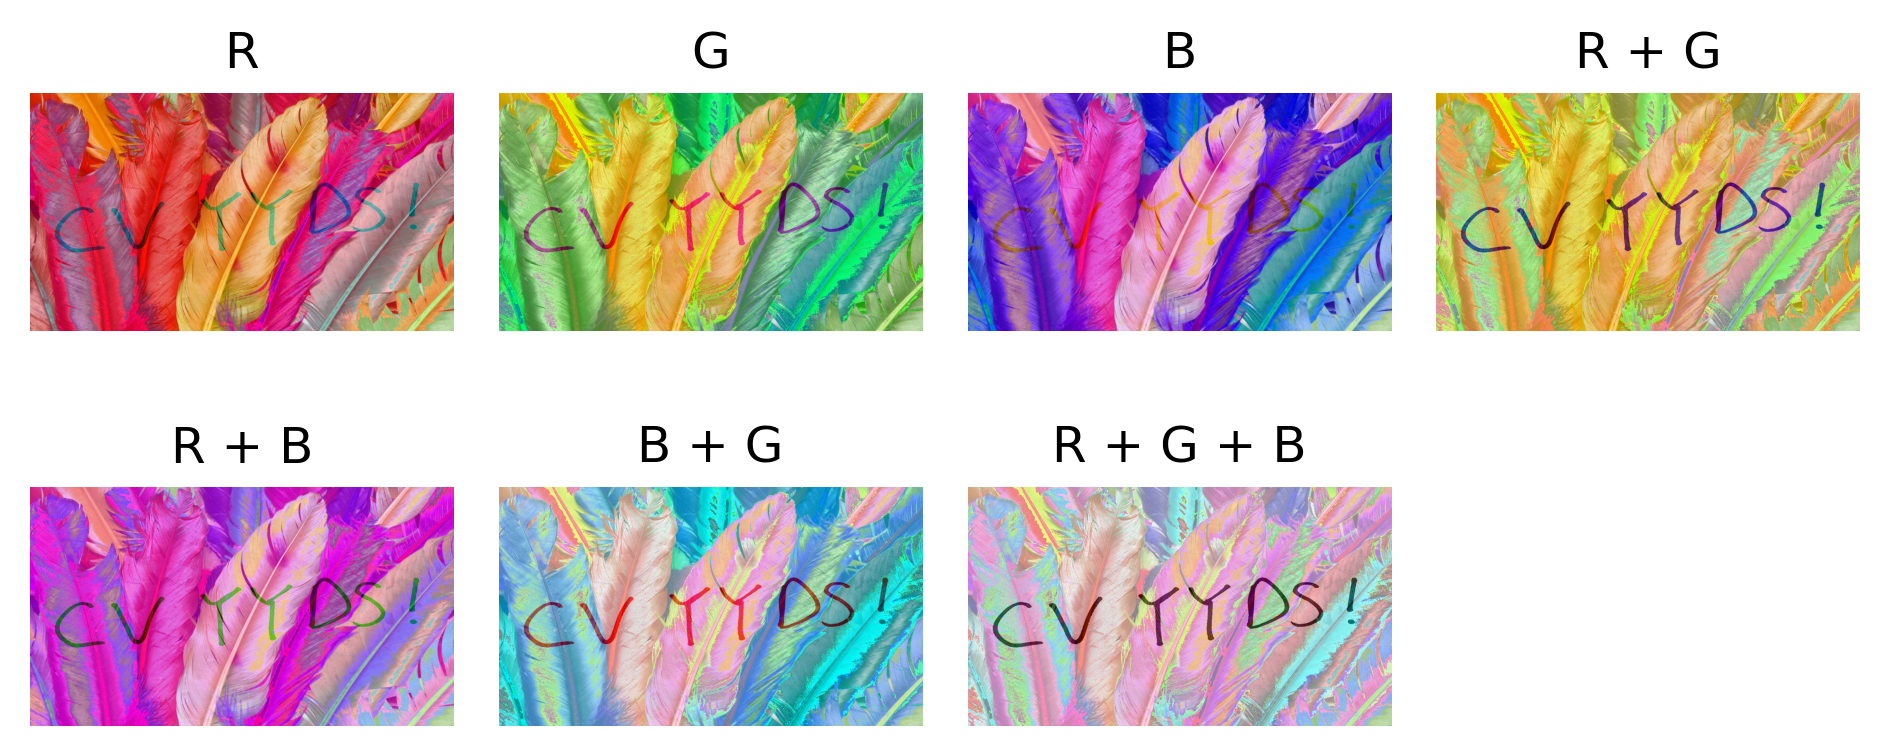

In [5]:
channels = cv2.split(I0)
channels_modified = []
plt.figure(dpi=300)
for channel in channels:
    mask = 1 << 7
    channel_modified = ((channel & ~mask) | (I2_binary << 7)).astype(np.uint8)
    channels_modified.append(channel_modified)

map = {
    'R': [channels[0], channels[1], channels_modified[2]],
    'G': [channels[0], channels_modified[1], channels[2]],
    'B': [channels_modified[0], channels[1], channels[2]],
    'R + G': [channels[0], channels_modified[1], channels_modified[2]],
    'R + B': [channels_modified[0], channels[1], channels_modified[2]],
    'B + G': [channels_modified[0], channels_modified[1], channels[2]],
    'R + G + B': [channels_modified[0], channels_modified[1], channels_modified[2]]
}

i = 1
for k, v in map.items():
    plt.subplot(2, 4, i);
    plt.axis('off')
    plt.title(k)
    plt.imshow(cv2.cvtColor(cv2.merge(v), cv2.COLOR_BGR2RGB))
    i += 1
plt.tight_layout()
plt.subplots_adjust(top=2, bottom=1.4)
plt.show()

## 分析

此处仅考虑变换每个通道的L8。

在仅改变单通道的时候，非“cv yyds”部分相应的通道值的最高位会被置为1，使得相应通道相应位置的像素值变大，而“cv yyds”二值图像的大部分位置的像素值都为255，这使得在仅改变单通道时图像的整体颜色偏向该通道代表的颜色。比如仅改变R通道时，修改后的图像的看上去整体更红；仅改变G通道时，修改后的图像的看上去整体更绿……改变多个通道时，也会呈现出相应通道颜色的叠加，如改变R+G通道时，图像的整体颜色偏黄……

随着改变的通道数的增加，“cv yyds”文字在图像中更加明显，如仅改变单通道时图像中呈现出的“cv yyds”不如三个通道都改变时图像呈现出的“cv yyds”文字。

注意到在仅改变B通道时，“cv yyds”字样不如仅改变R或G通道的字样，猜测这是因为原图像B通道的对比度不高；并且人眼对蓝色通道的感知能力弱于红色和绿色通道。

# 对附带彩色图像（I0）进行亮度变换、对比度变换、饱和度变换（变换程度自行确定）。对结果进行分析。

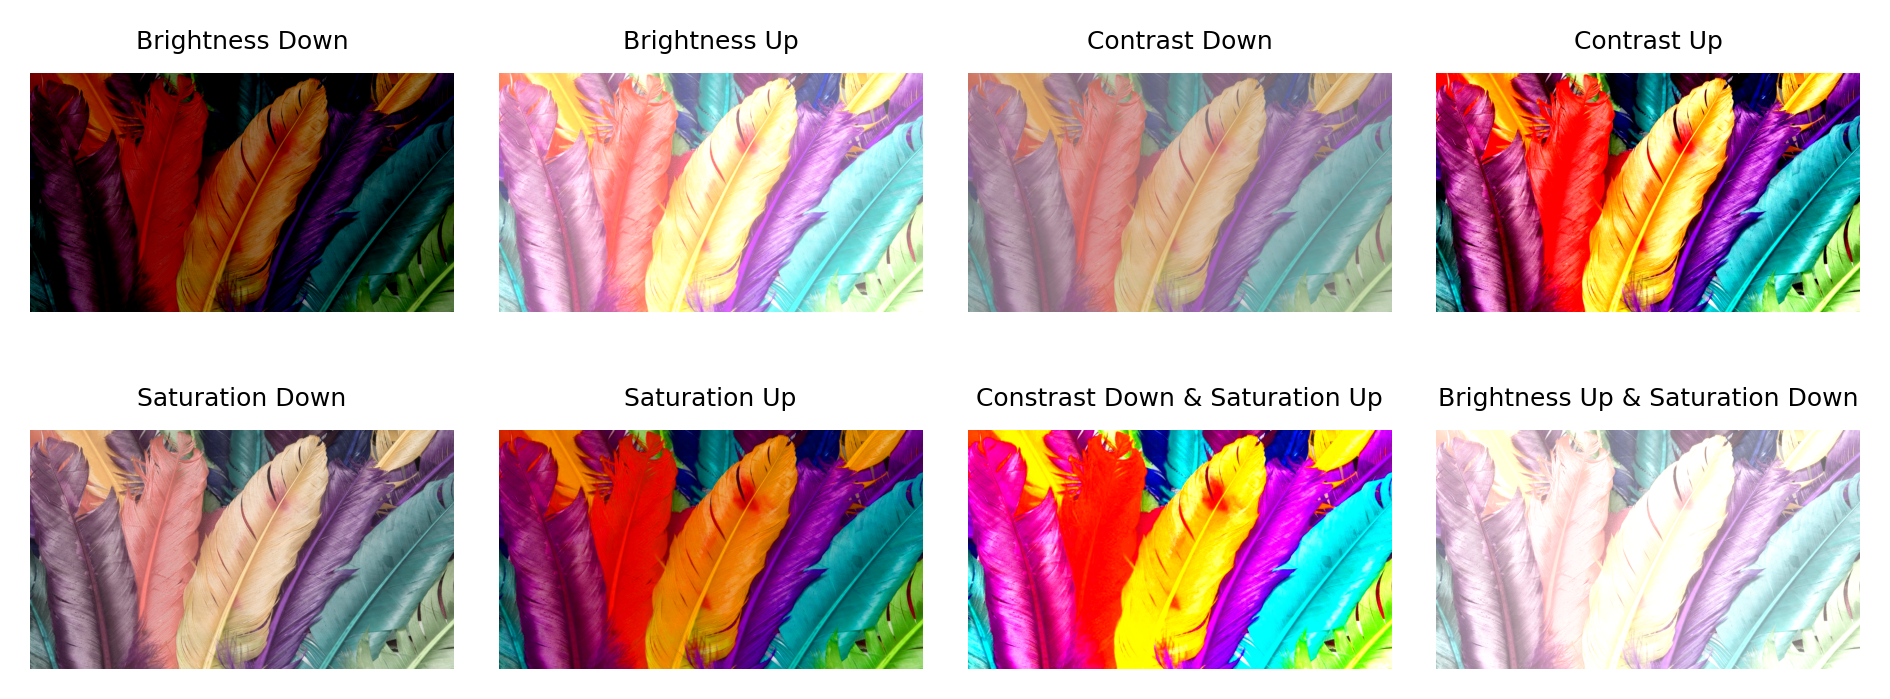

In [6]:
plt.figure(dpi=300)
I0_hsv = cv2.cvtColor(I0, cv2.COLOR_BGR2HSV)
map = {}
map['Brightness Down'] = cv2.addWeighted(I0, 1, I0, 0, -100)
map['Brightness Up'] = cv2.addWeighted(I0, 1, I0, 0, 100)
map['Contrast Down'] = cv2.addWeighted(I0, 0.5, I0, 0, 100)
map['Contrast Up'] = cv2.addWeighted(I0, 2, I0, 0, -100)
map['Saturation Down'] = cv2.cvtColor(cv2.merge([I0_hsv[:, :, 0], cv2.addWeighted(I0_hsv[:, :, 1], 0.5, I0_hsv[:, :, 1], 0, 0), I0_hsv[:, :, 2]]), cv2.COLOR_HSV2BGR)
map['Saturation Up'] = cv2.cvtColor(cv2.merge([I0_hsv[:, :, 0], cv2.addWeighted(I0_hsv[:, :, 1], 2, I0[:, :, 1], 0, 0), I0_hsv[:, :, 2]]), cv2.COLOR_HSV2BGR)
map['Constrast Down & Saturation Up'] = cv2.addWeighted(cv2.cvtColor(cv2.merge([I0_hsv[:, :, 0], cv2.addWeighted(I0_hsv[:, :, 1], 2, I0_hsv[:, :, 1], 0, 0), I0_hsv[:, :, 2]]), cv2.COLOR_HSV2BGR), 2, I0, 0, 0)
map['Brightness Up & Saturation Down'] = cv2.addWeighted(cv2.cvtColor(cv2.merge([I0_hsv[:, :, 0], cv2.addWeighted(I0_hsv[:, :, 1], 0.5, I0_hsv[:, :, 1], 0, 0), I0_hsv[:, :, 2]]), cv2.COLOR_HSV2BGR), 1, I0, 0, 100)

i = 1
for k, v in map.items():
    plt.subplot(2, 4, i);
    plt.axis('off')
    plt.title(k, fontsize=6)
    plt.imshow(cv2.cvtColor(v, cv2.COLOR_BGR2RGB))
    i += 1

plt.tight_layout()
plt.subplots_adjust(top=2, bottom=1.4)
plt.show()

## 分析

**亮度增加**
增加亮度意味着使图像看起来更亮。所有颜色都将向更亮的方向移动，使整个图像变得更明亮。但是过度增加亮度可能会导致图像的亮部细节丢失，因为亮度过高的过曝区域可能会全部变成纯白色。

实现：通过在cv2.addWeighted函数中设置alpha=1，beta=0（保持对比度不变）和gamma=100（将100加到图像的每个颜色通道），实现了亮度增加。addWeighted确保了最终的像素值被适当地限制在0到255内。

**对比度增加**
增加对比度会使图像的暗部更暗，亮部更亮，从而加深图像的整体差异，让图像看起来更有深度和细节。增加对比度通常可以让图像看起来更鲜明，更加吸引人。但是如果对比度增加过多，可能会导致暗部和亮部的细节丢失。

实现：通过在cv2.addWeighted函数中设置alpha=2，beta=0（保持对比度不变）和gamma=-100（将图像的每个颜色通道减100），实现了对比度增加。图像最亮的部分和最暗的部分的比值增大，像素值更加分散。

**饱和度增加**
增加饱和度会使图像的颜色看起来更鲜艳、更丰富。色彩将更加深和纯，但是如果饱和度提升过高，颜色可能会看起来不自然，甚至失真（比如L7中的大红色羽毛处的纹理丢失）。

实现：首先，使用cv2.cvtColor将图像从BGR颜色空间转换到HSV空间。在HSV空间中，饱和度是由S通道表示的。将S通道的每个像素值乘2。最后，将调整后的HSV图像重新合并，并转换回BGR颜色空间。